In [1]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [2]:
data = pd.read_csv('data/btc_data.csv', index_col=0)

In [3]:
data

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k,momentum,difficulty
2011-01-01,0.3000,0.292,0.3000,2821.24,8.419500e+02,0.3000,NaN,0.000000,0.000000,0,0.251628,0.272215,0.020587,75.041736,0.433468,5.683560e+03,0.018136,0.302597,0.209763,98.360656,0.060,NaN
2011-01-02,0.3000,0.289,0.3000,5352.11,1.584660e+03,0.3000,NaN,0.000000,0.000000,0,0.255211,0.276490,0.021279,74.831650,0.784203,4.098900e+03,0.018214,0.307253,0.213107,98.360656,0.050,NaN
2011-01-03,0.3000,0.290,0.3000,1425.19,4.208500e+02,0.2950,NaN,0.000000,-0.016667,0,0.258529,0.280107,0.021578,75.402884,0.227126,3.678050e+03,0.016429,0.311694,0.215676,98.360656,0.050,NaN
2011-01-04,0.2999,0.289,0.2950,1879.00,5.483300e+02,0.2989,NaN,-0.016667,0.013220,1,0.261230,0.282398,0.021168,64.583333,0.317246,3.129720e+03,0.015286,0.315355,0.216845,90.163934,0.047,NaN
2011-01-05,0.2990,0.290,0.2989,357.16,1.061900e+02,0.2990,NaN,0.013220,0.000335,1,0.264021,0.284937,0.020916,90.397805,0.063656,3.235910e+03,0.014000,0.318771,0.219319,96.500000,0.049,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-13,27110.9100,26674.970,26756.2300,18507.04,4.967794e+08,26862.9000,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.270529e+10,785.304286,28397.807436,25925.062564,10.940893,-750.990,5.732151e+13
2023-10-14,26982.7800,26810.020,26862.9000,5865.21,1.576854e+08,26854.5200,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.286298e+10,786.607857,28390.511290,25960.107710,16.135237,-565.760,5.732151e+13
2023-10-15,27297.2600,26813.060,26854.5200,10978.68,2.971100e+08,27177.4100,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.256587e+10,738.972857,28353.377450,26056.549550,15.727169,-935.280,5.732151e+13
2023-10-16,30009.1500,27131.480,27177.4100,66720.48,1.884463e+09,28518.3700,5.296435e+11,0.012024,0.049341,1,27097.032155,27171.610705,74.578550,38.382575,3.228924,1.445033e+10,848.527857,28315.553845,26182.321155,18.572004,-237.180,5.732151e+13


In [4]:
data['open'].describe()

count     4673.000000
mean     10010.712764
std      14842.749681
min          0.295000
25%        237.410000
50%       2052.430000
75%      11657.810000
max      67549.140000
Name: open, dtype: float64

In [5]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom', 'market_cap', 'difficulty']).iloc[:-1, :]
target = data['target'].iloc[:-1]

In [6]:
# Définir la taille de la fenêtre initiale
window_size = 1000

In [7]:
#Test avec RandomForest

"""  
# Initialiser les listes pour stocker les prédictions et les vraies valeurs
predictions = []
actuals = []

# Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
for i in range(window_size, len(data) - 1):
    # Diviser les données en ensembles d'entraînement et de test
    X_train = features.iloc[i-window_size:i, :]
    y_train = target.iloc[i-window_size:i]
    X_test = features.iloc[i:i+1, :]
    y_test = target.iloc[i]

    #Normaliser les données
    scaler = StandardScaler()
    X_train_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Entraîner un modèle
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # Faire une prédiction
    prediction = model.predict(X_test)[0]
    
    # Stocker les prédictions et les vraies valeurs
    predictions.append(prediction)
    actuals.append(y_test)

# Évaluer le modèle
accuracy = accuracy_score(actuals, predictions)
print(f'Model Accuracy: {accuracy * 100:.2f}%')"""


"  \n# Initialiser les listes pour stocker les prédictions et les vraies valeurs\npredictions = []\nactuals = []\n\n# Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données\nfor i in range(window_size, len(data) - 1):\n    # Diviser les données en ensembles d'entraînement et de test\n    X_train = features.iloc[i-window_size:i, :]\n    y_train = target.iloc[i-window_size:i]\n    X_test = features.iloc[i:i+1, :]\n    y_test = target.iloc[i]\n\n    #Normaliser les données\n    scaler = StandardScaler()\n    X_train_train = scaler.fit_transform(X_train)\n    X_test = scaler.transform(X_test)\n    \n    # Entraîner un modèle\n    model = RandomForestClassifier()\n    model.fit(X_train, y_train)\n    \n    # Faire une prédiction\n    prediction = model.predict(X_test)[0]\n    \n    # Stocker les prédictions et les vraies valeurs\n    predictions.append(prediction)\n    actuals.append(y_test)\n\n# Évaluer le modèle\naccuracy = accuracy_score(actuals, predictions)\

In [8]:
def train_model(data, model, features, target, window_size):
      
      # Initialiser les listes pour stocker les prédictions et les vraies valeurs
      predictions = []
      actuals = []

      # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
      for i in range(window_size, len(data) - 1):
            # Diviser les données en ensembles d'entraînement et de test
            X_train = features.iloc[i-window_size:i, :]
            y_train = target.iloc[i-window_size:i]
            X_test = features.iloc[i:i+1, :]
            y_test = target.iloc[i]

            #Normaliser les données
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Entraîner un modèle
            model.fit(X_train, y_train)
            
            # Faire une prédiction
            prediction = model.predict(X_test)[0]
            
            # Stocker les prédictions et les vraies valeurs
            predictions.append(prediction)
            actuals.append(y_test)

      # Évaluer le modèle
      accuracy = accuracy_score(actuals, predictions)
      print(f'Model Accuracy: {accuracy * 100:.2f}%')

In [9]:
dummy_model = DummyClassifier(strategy="most_frequent")
train_model(data, dummy_model, features, target, window_size)

Model Accuracy: 52.23%


In [10]:
"""from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
train_model(data, logistic_regression, features, target, window_size)"""

'from sklearn.linear_model import LogisticRegression\nlogistic_regression = LogisticRegression()\ntrain_model(data, logistic_regression, features, target, window_size)'

In [12]:
"""xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
train_model(data, xgboost, features, target, window_size)"""

"xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')\ntrain_model(data, xgboost, features, target, window_size)"

In [13]:
def plot_feature_importance(model, feature_names):
    # Récupérer les coefficients du modèle
    coefficients = model.coef_[0]
    
    # Créer un DataFrame pour stocker les caractéristiques et leurs importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    })
    
    # Trier le DataFrame en fonction de l'importance
    feature_importance = feature_importance.sort_values(by='Importance', key=abs, ascending=False)
    
    # Visualiser l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance for Logistic Regression')
    plt.gca().invert_yaxis()  # Pour afficher la caractéristique la plus importante en haut
    plt.show()

In [14]:
def plot_feature_importance_xgb(model, feature_names):
    # Récupérer les importances des caractéristiques du modèle XGBoost
    importances = model.feature_importances_
    
    # Créer un DataFrame pour stocker les caractéristiques et leurs importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Trier le DataFrame en fonction de l'importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    # Visualiser l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance for XGBoost')
    plt.gca().invert_yaxis()  # Pour afficher la caractéristique la plus importante en haut
    plt.show()

In [15]:
"""plot_feature_importance(logistic_regression, features.columns)"""

'plot_feature_importance(logistic_regression, features.columns)'

In [16]:
from sklearn.metrics import log_loss

def train_model_proba(data, model, features, target, window_size):
      
    # Initialiser les listes pour stocker les probabilités prédites et les vraies valeurs
    predicted_probs = []
    actuals = []

    # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
    for i in range(window_size, len(data) - 1):
        # Diviser les données en ensembles d'entraînement et de test
        X_train = features.iloc[i-window_size:i, :]
        y_train = target.iloc[i-window_size:i]
        X_test = features.iloc[i:i+1, :]
        y_test = target.iloc[i]

        # Normaliser les données
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Entraîner un modèle
        model.fit(X_train, y_train)
        
        # Obtenir les probabilités prédites pour la classe positive (par exemple, 1)
        prediction_prob = model.predict_proba(X_test)[:, 1]
        
        # Stocker les probabilités prédites et les vraies valeurs
        predicted_probs.extend(prediction_prob)
        actuals.append(y_test)

    # Calculer la Log Loss
    loss = log_loss(actuals, predicted_probs)
    print(f'Log Loss: {loss:.4f}')

In [17]:
"""train_model_proba(data, logistic_regression, features, target, window_size)"""

'train_model_proba(data, logistic_regression, features, target, window_size)'

In [18]:
def earn_metric(predicted_probs, progressions, n_days, i):
      base = c = 1
      for j in range(n_days):
            index = len(predicted_probs) - n_days + j
            c *= predicted_probs[index] * progressions[index] + (1 - predicted_probs[index])
            base *= progressions[index]
      return c / base


def train_model_proba_metric(data, model, features, target, window_size, n_days):
      
    # Initialiser les listes pour stocker les probabilités prédites et les vraies valeurs
    predicted_probs = []
    progressions = []
    metric = []

    # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
    for i in range(window_size, len(data) - 1):
        # Diviser les données en ensembles d'entraînement et de test
        X_train = features.iloc[i-window_size:i, :]
        y_train = target.iloc[i-window_size:i]
        X_test = features.iloc[i:i+1, :]
        y_test = target.iloc[i]

        # Normaliser les données
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Entraîner un modèle
        model.fit(X_train, y_train)
        
        # Obtenir les probabilités prédites pour la classe positive (par exemple, 1)
        prediction_prob = model.predict_proba(X_test)[:, 1]
        
        # Stocker les probabilités prédites et les vraies valeurs
        predicted_probs.extend(prediction_prob)
        
        # Récupérer la progression réelle
        progressions.append(data.iloc[i]['progression tomorrow']+1)

        if i >= window_size + n_days:
            metric.append(earn_metric(predicted_probs, progressions, n_days, i))
    
    return np.mean(metric) 

In [19]:
n_days = 31

"""train_model_proba_metric(data, xgboost, features, target, window_size, n_days)"""

'train_model_proba_metric(data, xgboost, features, target, window_size, n_days)'

In [20]:
def train_model_grid(data, model, features, target, window_size):
      
      # Initialiser les listes pour stocker les prédictions et les vraies valeurs
      predictions = []
      actuals = []

      # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
      for i in range(window_size, len(data) - 1):
            # Diviser les données en ensembles d'entraînement et de test
            X_train = features.iloc[i-window_size:i, :]
            y_train = target.iloc[i-window_size:i]
            X_test = features.iloc[i:i+1, :]
            y_test = target.iloc[i]

            #Normaliser les données
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Entraîner un modèle
            model.fit(X_train, y_train)
            
            # Faire une prédiction
            prediction = model.predict(X_test)[0]
            
            # Stocker les prédictions et les vraies valeurs
            predictions.append(prediction)
            actuals.append(y_test)

      # Évaluer le modèle
      accuracy = accuracy_score(actuals, predictions)
      return accuracy

In [21]:
# Définir la grille de paramètres
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200, 500],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [22]:
param_grid_xgb_reduced = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [23]:
"""from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
from IPython.display import display, HTML


# Créer une liste de combinaisons de paramètres
grid_list = list(ParameterGrid(param_grid_xgb_reduced))

# Pour boucler sur chaque combinaison :
best_accuracy = 0
best_params = None

for params in grid_list:
    try:
        # Instancier le modèle avec les paramètres
        model_instance = XGBClassifier(**params)
        
        # Appliquer la fonction train_model
        accuracy = train_model_grid(data, model_instance, features, target, window_size)
        
        # Si le modèle actuel a une meilleure précision que le précédent meilleur modèle, stocker sa précision et ses paramètres
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            print(f"Nouveaux meilleurs paramètres trouvés : {params}, accuracy : {accuracy}")

        
            
    except Exception as e:
        # Gérer les combinaisons de paramètres non compatibles
        error_message = f"Error with parameters {params}: {e}"
        #display(HTML(f"<small>{error_message}</small>"))
        #pass

print(f"Best Model Accuracy: {best_accuracy * 100:.2f}%")
print(f"Best Parameters: {best_params}")
"""

'from sklearn.model_selection import ParameterGrid\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.metrics import accuracy_score\nwarnings.filterwarnings(\'ignore\', category=FutureWarning, module=\'sklearn\')\nfrom IPython.display import display, HTML\n\n\n# Créer une liste de combinaisons de paramètres\ngrid_list = list(ParameterGrid(param_grid_xgb_reduced))\n\n# Pour boucler sur chaque combinaison :\nbest_accuracy = 0\nbest_params = None\n\nfor params in grid_list:\n    try:\n        # Instancier le modèle avec les paramètres\n        model_instance = XGBClassifier(**params)\n        \n        # Appliquer la fonction train_model\n        accuracy = train_model_grid(data, model_instance, features, target, window_size)\n        \n        # Si le modèle actuel a une meilleure précision que le précédent meilleur modèle, stocker sa précision et ses paramètres\n        if accuracy > best_accuracy:\n            best_accur

In [24]:
"""Best Model Accuracy: 60.57%
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}"""

"Best Model Accuracy: 60.57%\nBest Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}"

In [25]:
best_params_xgb = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

In [27]:
"""xgboost = XGBClassifier(**best_params_xgb)

train_model_proba_metric(data, xgboost, features, target, window_size, n_days)"""
#Accuracy : 0.60

'xgboost = XGBClassifier(**best_params_xgb)\n\ntrain_model_proba_metric(data, xgboost, features, target, window_size, n_days)'

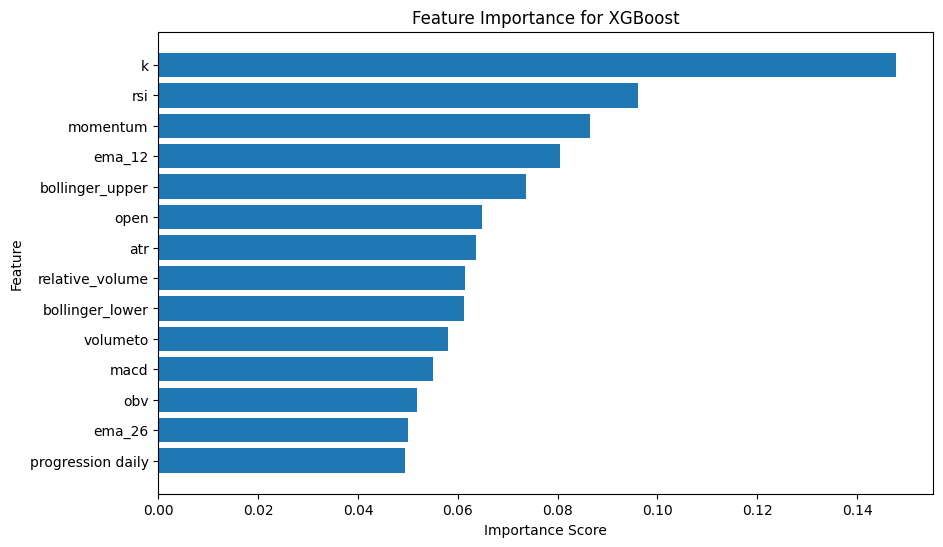

In [31]:
feature_names = features.columns.tolist()
plot_feature_importance_xgb(xgboost, feature_names)

In [ ]:
"""best params au bout de 16h d'exec : 

{'C': 0.001,
 'class_weight': None,
 'fit_intercept': True,
 'l1_ratio': 0.1,
 'max_iter': 100,
 'penalty': 'none',
 'solver': 'sag'}

 acccuracy minable de 0.568082788671024
 
 """

In [28]:
data_crop = data.dropna()

In [29]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data_crop.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom']).iloc[:-1, :]
target = data['target'].iloc[:-1]

# Définir la taille de la fenêtre initiale
window_size = 1000

# Définir la taille de le fenêtre pour calculer la métrique
n_days = 31

In [30]:
dummy_model = DummyClassifier(strategy="most_frequent")
train_model(data_crop, dummy_model, features, target, window_size)

Model Accuracy: 53.29%


In [34]:
best_params_xgb = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

xgboost = XGBClassifier(**best_params_xgb, random_state = 42)

In [ ]:
train_model(data_crop, xgboost, features, target, window_size)

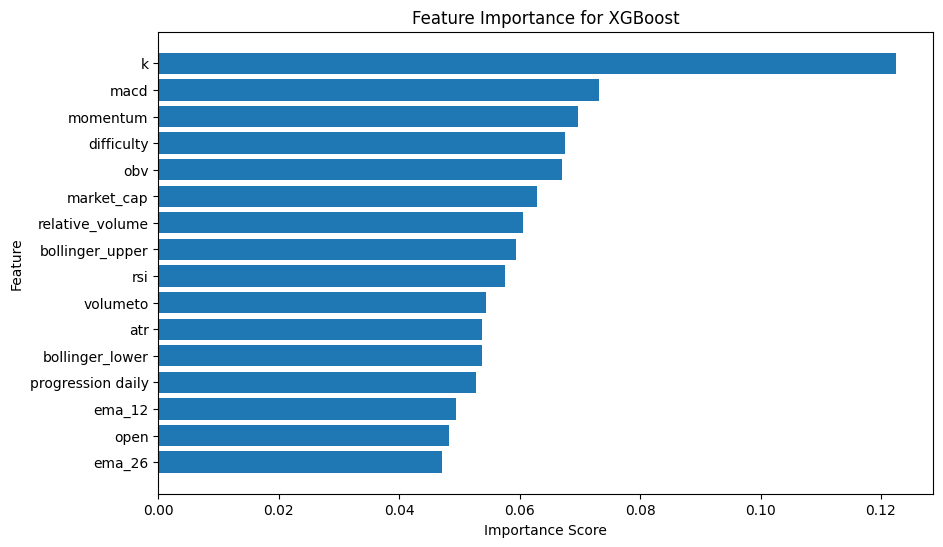

In [29]:
plot_feature_importance_xgb(xgboost, feature_names=features.columns.tolist())

In [36]:
import shap
import numpy as np
import xgboost as xgb
xgb.set_config(verbosity=0)  # 0 pour ignorer les avertissements, 1 pour les afficher


def train_model_with_shap(data, model, features, target, window_size):
      
    # Initialiser les listes pour stocker les prédictions, les vraies valeurs et les valeurs SHAP
    predictions = []
    actuals = []
    all_shap_values = []

    # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
    for i in range(window_size, len(data) - 1):
        # Diviser les données en ensembles d'entraînement et de test
        X_train = features.iloc[i-window_size:i, :]
        y_train = target.iloc[i-window_size:i]
        X_test = features.iloc[i:i+1, :]
        y_test = target.iloc[i]

        # Normaliser les données
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entraîner un modèle
        model.fit(X_train_scaled, y_train)
        
        # Faire une prédiction
        prediction = model.predict(X_test_scaled)[0]
        
        # Stocker les prédictions et les vraies valeurs
        predictions.append(prediction)
        actuals.append(y_test)

        # Créez un explainer SHAP pour le modèle actuel
        explainer = shap.Explainer(model)
        
        # Calculez les valeurs SHAP pour l'ensemble d'entraînement actuel
        shap_values = explainer.shap_values(X_train_scaled)
        
        # Ajoutez les valeurs SHAP à la liste
        all_shap_values.append(shap_values)

    # Calculer l'importance moyenne des caractéristiques sur toutes les fenêtres
    mean_shap_values = np.mean(all_shap_values, axis=0)

    # Visualiser l'importance moyenne des caractéristiques
    shap.summary_plot(mean_shap_values, X_train, plot_type="bar")

    # Évaluer le modèle
    accuracy = accuracy_score(actuals, predictions)
    print(f'Model Accuracy: {accuracy * 100:.2f}%')

    return mean_shap_values


In [37]:
train_model_with_shap(data_crop, xgboost, features, target, window_size)

In [40]:
train_model_proba_metric(data_crop, xgboost, features, target, window_size, n_days)

0.9891143112128489

In [57]:
def train_model_full_data(data, model, features, target):
      
      # Initialiser les listes pour stocker les prédictions et les vraies valeurs
      predictions = []
      actuals = []

      # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
      for i in range(1, len(data) - 1):
            # Diviser les données en ensembles d'entraînement et de test
            X_train = features.iloc[:i, :]
            y_train = target.iloc[:i]
            X_test = features.iloc[i:i+1, :]
            y_test = target.iloc[i]

            #Normaliser les données
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Entraîner un modèle
            model.fit(X_train, y_train)
            
            # Faire une prédiction
            prediction = model.predict(X_test)[0]
            
            # Stocker les prédictions et les vraies valeurs
            predictions.append(prediction)
            actuals.append(y_test)

      # Évaluer le modèle
      accuracy = accuracy_score(actuals, predictions)
      print(f'Model Accuracy: {accuracy * 100:.2f}%')

In [58]:
def train_model_proba_metric_full_data(data, model, features, target, start_size, n_days):
      
    # Initialiser les listes pour stocker les probabilités prédites et les vraies valeurs
    predicted_probs = []
    progressions = []
    metric = []

    # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
    for i in range(start_size, len(data) - 1):
        # Diviser les données en ensembles d'entraînement et de test
        X_train = features.iloc[:i, :]
        y_train = target.iloc[:i]
        X_test = features.iloc[i:i+1, :]
        y_test = target.iloc[i]

        # Normaliser les données
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Entraîner un modèle
        model.fit(X_train, y_train)
        
        # Obtenir les probabilités prédites pour la classe positive (par exemple, 1)
        prediction_prob = model.predict_proba(X_test)[:, 1]
        
        # Stocker les probabilités prédites et les vraies valeurs
        predicted_probs.extend(prediction_prob)
        
        # Récupérer la progression réelle
        progressions.append(data.iloc[i]['progression tomorrow']+1)

        if i >= start_size + n_days:
            metric.append(earn_metric(predicted_probs, progressions, n_days, i))
    
    return np.mean(metric) 

In [59]:
start_size = 100

In [60]:
train_model_proba_metric_full_data(data_crop, xgboost, features, target, start_size, n_days)

0.9979848516844735